In [95]:
# import kfold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import torch
import pandas as pd

In [96]:
classesDF  = pd.read_csv('../../../data/elliptic_txs_classes.csv')

# Remove all nodes that have unknown class
classesDF = classesDF[classesDF['class'] != "unknown"]

# If class = 2, then map to 0, else map to 1
classesDF['class'] = classesDF['class'].map({'2': 0, '1': 1})

classesDF.head(5)

,txId,class
3,232438397,0
9,232029206,0
10,232344069,0
11,27553029,0
16,3881097,0


In [97]:
featuresDF = pd.read_csv('../../../data/elliptic_txs_features.csv')

# Change column names --> Column 1 is txId, Column 2 is timestep and the rest are unknown features
featuresDF.columns = ['txId', 'timestep'] + ['f' + str(i) for i in range(165)]

# Remove all edges that do not appear in classesDF
featuresDF = featuresDF[featuresDF['txId'].isin(classesDF['txId'])]

featuresDF.head(5)

,txId,timestep,f0,f1,f2,f3,f4,f5,f6,f7,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
8,232029206,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
9,232344069,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.137933,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
10,27553029,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.141519,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
15,3881097,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,-0.163640,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [98]:
# Append the class to the featuresDF based on txID
featuresDF = featuresDF.merge(classesDF, on='txId')

# Move features 'class' to first column
cols = list(featuresDF.columns)
cols = cols[:1] + [cols[-1]] + cols[1:-1]
featuresDF = featuresDF[cols]

featuresDF.head(5)

,txId,class,timestep,f0,f1,f2,f3,f4,f5,f6,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
0,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
1,232029206,0,1,-0.005027,0.578941,-0.091383,4.380281,-0.063725,4.667146,0.851305,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
2,232344069,0,1,-0.147852,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
3,27553029,0,1,-0.151357,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
4,3881097,0,1,-0.172306,-0.184668,-1.201369,0.028105,-0.043875,-0.029140,0.242712,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [99]:
positive_features = featuresDF[featuresDF['class'] == 1]
negative_features = featuresDF[featuresDF['class'] == 0]

# Get the number of positive and negative samples
n_pos = positive_features.shape[0]
n_neg = negative_features.shape[0]

print("Number of positive samples: ", n_pos)
print("Number of negative samples: ", n_neg)

Number of positive samples:  4545
Number of negative samples:  42019


## Train the classifier with unbalanced data using Kfolds

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [101]:
# remove the class column and node id for training data
X = featuresDF.iloc[:, 2:]

# use only the class column for the target data
y = featuresDF.iloc[:, 1]

In [102]:
# Prepare to store the splits
n_splits = 5
folds_class1 = [[] for _ in range(n_splits)]
folds_class2 = [[] for _ in range(n_splits)]

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create empty lists to hold the indices for each fold
folds_class1 = [[] for _ in range(n_splits)]
folds_class2 = [[] for _ in range(n_splits)]

# Split each class into folds
for fold_idx, (_, test_idx) in enumerate(kf.split(positive_features)):
    folds_class1[fold_idx] = test_idx.tolist()

for fold_idx, (_, test_idx) in enumerate(kf.split(negative_features)):
    folds_class2[fold_idx] = test_idx.tolist()

# Combine the class-specific folds into overall folds
folds = []
for i in range(n_splits):
    test_indices_class1 = folds_class1[i]
    test_indices_class2 = folds_class2[i]
    train_indices_class1 = sum([folds_class1[j] for j in range(n_splits) if j != i], [])
    train_indices_class2 = sum([folds_class2[j] for j in range(n_splits) if j != i], [])
    
    train_indices = train_indices_class1 + train_indices_class2
    test_indices = test_indices_class1 + test_indices_class2
    
    folds.append((train_indices, test_indices))

In [103]:
# Store the folds
torch.save(folds, 'unbalanced_folds.pt')

Fold 1 - Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8414
           1       1.00      0.88      0.94       899

    accuracy                           0.99      9313
   macro avg       0.99      0.94      0.96      9313
weighted avg       0.99      0.99      0.99      9313



Fold 2 - Metrics:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8394
           1       1.00      0.85      0.92       919

    accuracy                           0.98      9313
   macro avg       0.99      0.92      0.95      9313
weighted avg       0.98      0.98      0.98      9313



Fold 3 - Metrics:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8386
           1       1.00      0.88      0.94       927

    accuracy                           0.99      9313
   macro avg       0.99      0.94      0.96      9313
weighted avg    

<Figure size 1000x700 with 0 Axes>

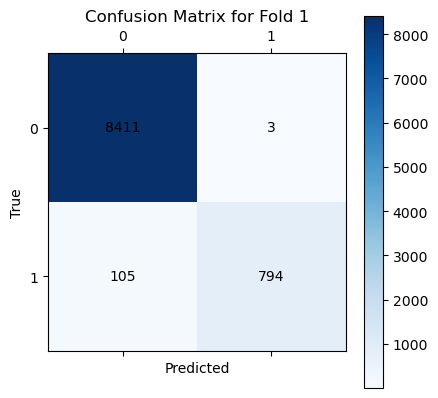

<Figure size 1000x700 with 0 Axes>

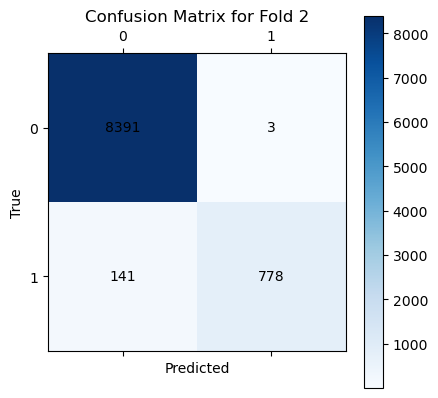

<Figure size 1000x700 with 0 Axes>

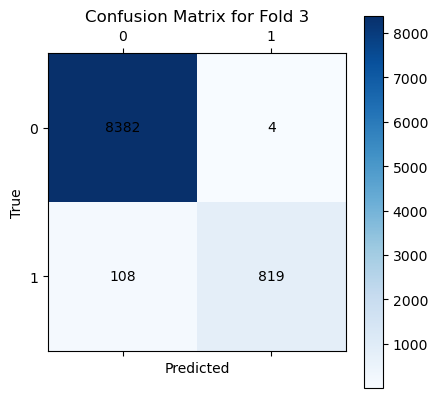

<Figure size 1000x700 with 0 Axes>

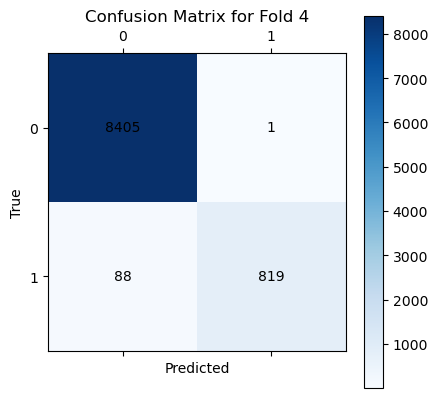

<Figure size 1000x700 with 0 Axes>

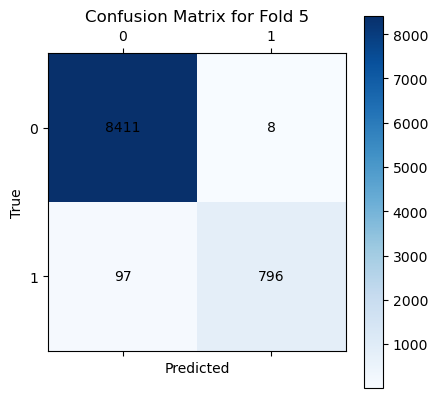

In [104]:
# List to store metrics for each fold
metrics = []

for index, (train_indices, test_indices) in enumerate(kf.split(X)):  
    X_train, X_test = X.iloc[train_indices].values, X.iloc[test_indices].values
    y_train, y_test = y.iloc[train_indices].values, y.iloc[test_indices].values
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train your model (replace with your model training)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)  
    clf.fit(X_train, y_train)
    
    # Predict and compute metrics (replace with your metric computation)
    y_pred = clf.predict(X_test)
    metric = accuracy_score(y_test, y_pred)  # Replace with your desired metric
    metrics.append(metric)

    print(f'Fold {index + 1} - Metrics:\n{classification_report(y_test, y_pred)}\n\n')

    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 7))
    plt.matshow(conf_matrix, cmap='Blues')
    plt.colorbar()
    for i in range(2):
        for j in range(2):
            plt.text(i, j, str(conf_matrix[j, i]), ha='center', va='center')
    plt.title('Confusion Matrix for Fold ' + str(index + 1))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'cm_fold_{index + 1}.png')

# Compute the average metric
average_metric = sum(metrics) / len(metrics)
print(f'Average Metric: {average_metric}')

## Train the classifier with balanced data using kFolding

We will split the data in different balanced subsets and then train the models using kfolding.

In [105]:
import random

Random balancing of the dataset number 0:
Fold 1 - Metrics:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       905
           1       1.00      0.93      0.96       913

    accuracy                           0.96      1818
   macro avg       0.96      0.96      0.96      1818
weighted avg       0.96      0.96      0.96      1818


Fold 2 - Metrics:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       970
           1       0.99      0.94      0.97       848

    accuracy                           0.97      1818
   macro avg       0.97      0.97      0.97      1818
weighted avg       0.97      0.97      0.97      1818


Fold 3 - Metrics:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       864
           1       0.99      0.94      0.97       954

    accuracy                           0.96      1818
   macro avg       0.96      0

C:\Users\polme\AppData\Local\Temp\ipykernel_14368\2010184147.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 7))


Fold 2 - Metrics:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       970
           1       0.99      0.94      0.97       848

    accuracy                           0.97      1818
   macro avg       0.97      0.97      0.97      1818
weighted avg       0.97      0.97      0.97      1818


Fold 3 - Metrics:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       864
           1       0.98      0.94      0.96       954

    accuracy                           0.96      1818
   macro avg       0.96      0.96      0.96      1818
weighted avg       0.96      0.96      0.96      1818


Fold 4 - Metrics:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       894
           1       0.99      0.94      0.96       924

    accuracy                           0.96      1818
   macro avg       0.97      0.96      0.96      1818
weighted avg      

<Figure size 1000x700 with 0 Axes>

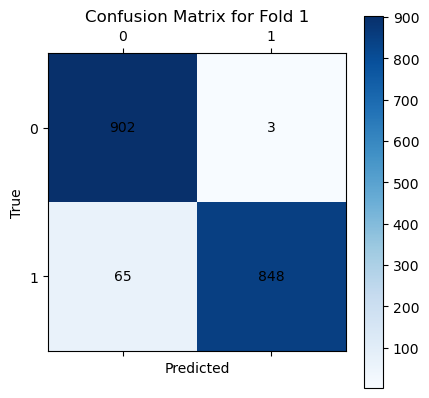

<Figure size 1000x700 with 0 Axes>

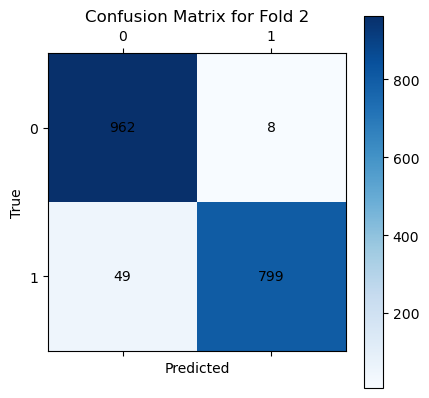

<Figure size 1000x700 with 0 Axes>

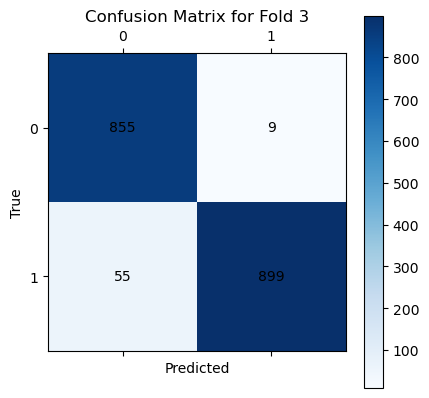

<Figure size 1000x700 with 0 Axes>

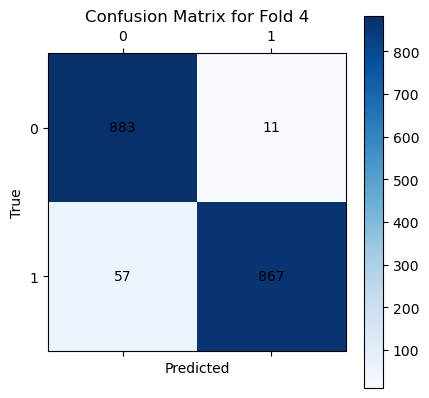

<Figure size 1000x700 with 0 Axes>

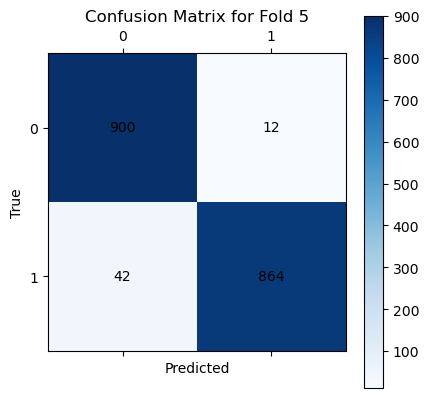

<Figure size 1000x700 with 0 Axes>

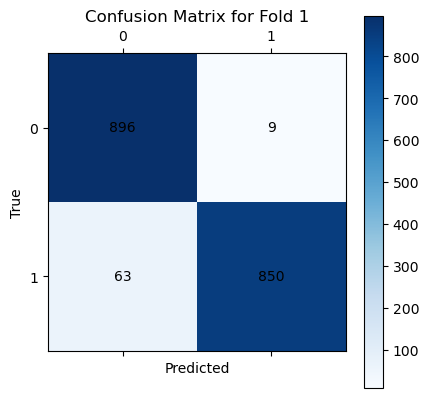

<Figure size 1000x700 with 0 Axes>

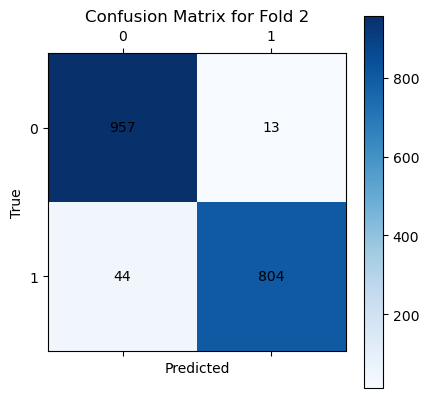

<Figure size 1000x700 with 0 Axes>

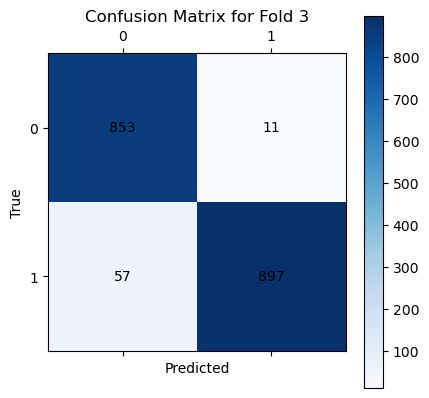

<Figure size 1000x700 with 0 Axes>

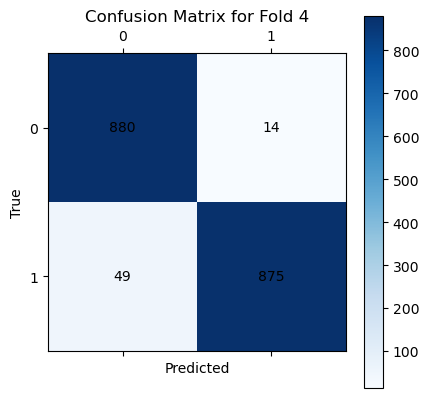

<Figure size 1000x700 with 0 Axes>

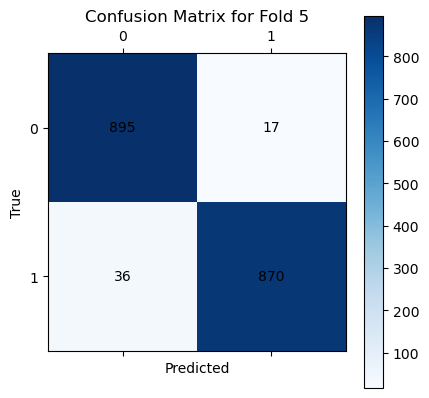

<Figure size 1000x700 with 0 Axes>

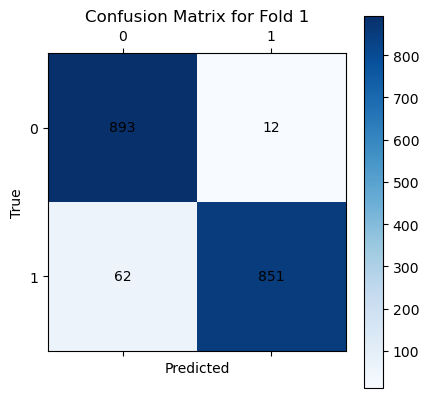

<Figure size 1000x700 with 0 Axes>

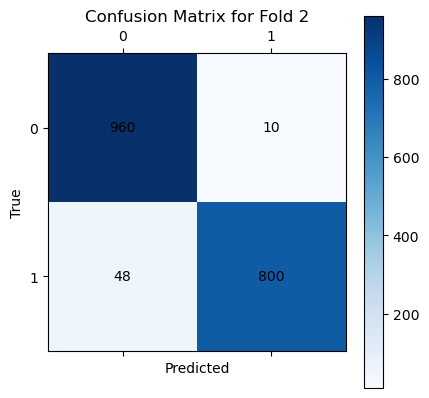

<Figure size 1000x700 with 0 Axes>

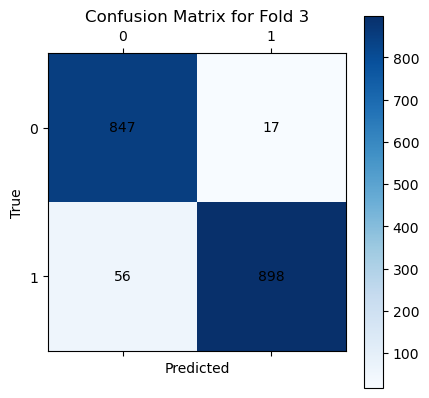

<Figure size 1000x700 with 0 Axes>

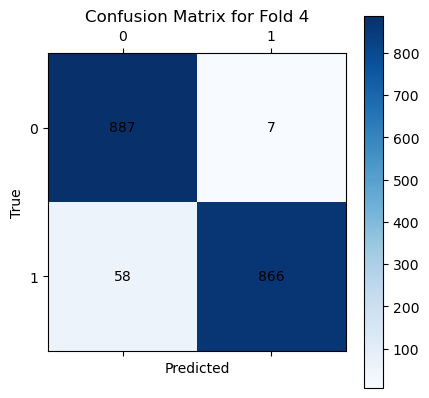

<Figure size 1000x700 with 0 Axes>

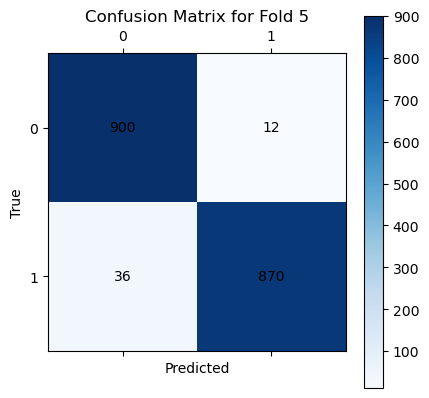

<Figure size 1000x700 with 0 Axes>

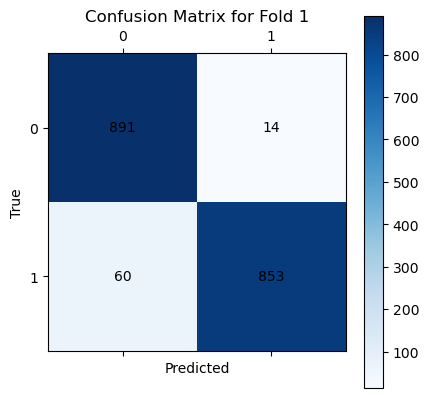

<Figure size 1000x700 with 0 Axes>

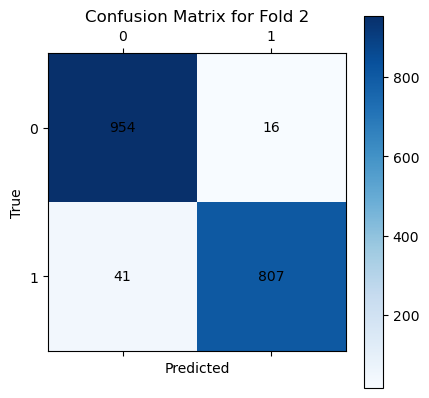

<Figure size 1000x700 with 0 Axes>

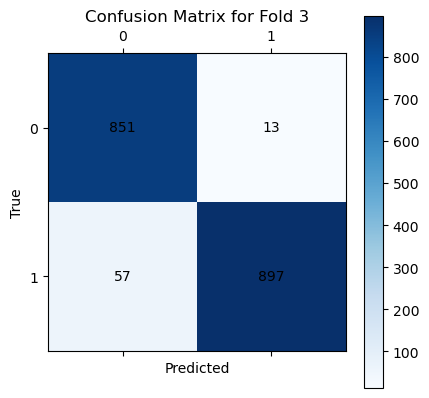

<Figure size 1000x700 with 0 Axes>

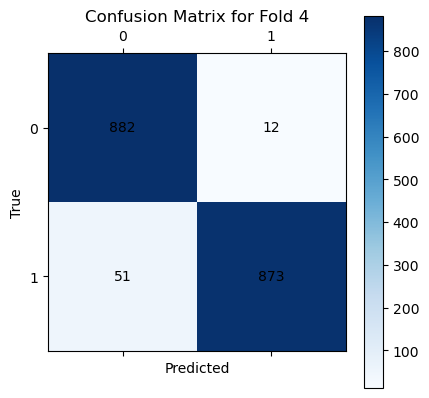

<Figure size 1000x700 with 0 Axes>

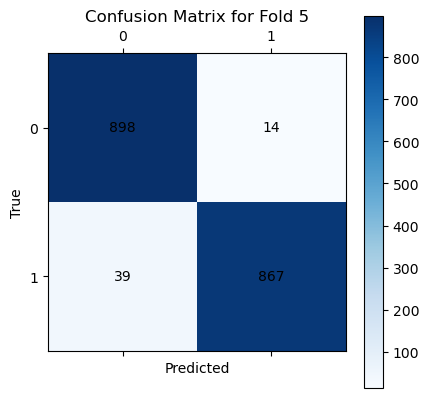

<Figure size 1000x700 with 0 Axes>

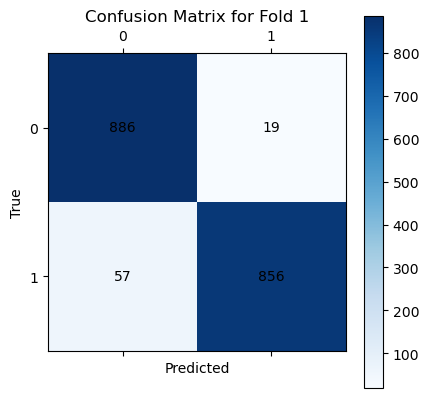

<Figure size 1000x700 with 0 Axes>

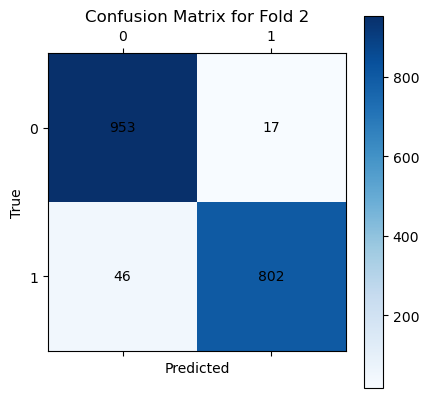

<Figure size 1000x700 with 0 Axes>

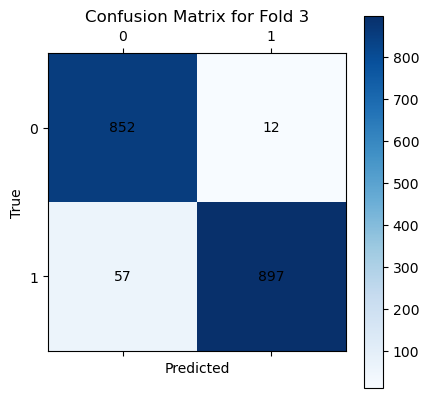

<Figure size 1000x700 with 0 Axes>

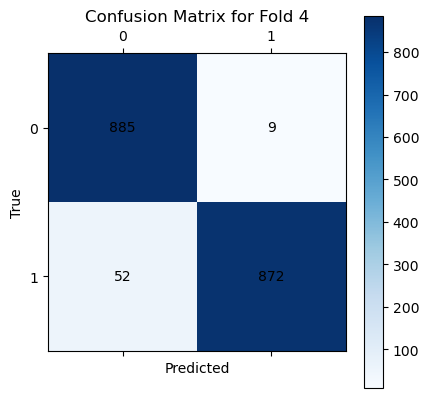

<Figure size 1000x700 with 0 Axes>

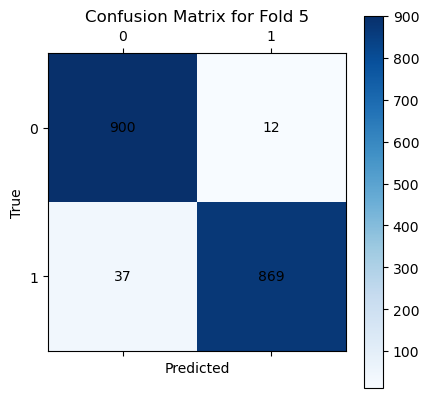

In [106]:
total_samples_for_class = len(positive_features)

# store metrics for 5 random splits
overall_metrics = []

for balance_idx, _ in enumerate(range(5)):
    print(f"Random balancing of the dataset number {balance_idx}:")
    balanced_negatives = negative_features.sample(n=total_samples_for_class,
                                                  random_state=random.seed())
    balanced_features = pd.concat([balanced_negatives, positive_features])

    # remove the class column and node id for training data
    X = balanced_features.iloc[:, 2:]
    # use only the class column for the target data
    y = balanced_features.iloc[:, 1]

    # List to store metrics for each fold
    metrics = []

    for index, (train_indices, test_indices) in enumerate(kf.split(X)):  
        X_train, X_test = X.iloc[train_indices].values, X.iloc[test_indices].values
        y_train, y_test = y.iloc[train_indices].values, y.iloc[test_indices].values
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Train your model (replace with your model training)
        clf = RandomForestClassifier(n_estimators=100, random_state=42)  
        clf.fit(X_train, y_train)
        
        # Predict and compute metrics (replace with your metric computation)
        y_pred = clf.predict(X_test)
        metric = accuracy_score(y_test, y_pred)  # Replace with your desired metric
        metrics.append(metric)

        print(f'Fold {index + 1} - Metrics:\n{classification_report(y_test, y_pred)}\n')

        conf_matrix = confusion_matrix(y_test, y_pred)

        plt.figure(figsize=(10, 7))
        plt.matshow(conf_matrix, cmap='Blues')
        plt.colorbar()
        for i in range(2):
            for j in range(2):
                plt.text(i, j, str(conf_matrix[j, i]), ha='center', va='center')
        plt.title('Confusion Matrix for Fold ' + str(index + 1))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'cm_balance_{balance_idx}_fold_{index + 1}.png')

    # Compute the average metric
    average_metric = sum(metrics) / len(metrics)
    overall_metrics.append(metrics)
    print(f'Average Metric: {average_metric}\n\n')